In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
import os
import requests

In [39]:
load_dotenv()
# model = ChatOllama(model="gpt-oss:20b-cloud")
# model = ChatOllama(model="gemini-3-pro-preview:latest")
# model = ChatOllama(model="qwen3-vl:235b-instruct-cloud")
model = ChatOllama(model="qwen3-coder:480b-cloud")

In [40]:
search_tool = DuckDuckGoSearchRun(region="us-en")

@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}'"}
        
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}

@tool
def get_stock_price(symbol: str) -> dict:
    """
    Fetch latest stock price for a given symbol (e.g. 'AAPL', 'TSLA') 
    using Alpha Vantage with API key in the URL.
    """
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey={os.getenv('ALPHA_VANTAGE_API_KEY')}"
    r = requests.get(url)
    return r.json()

tools = [search_tool, calculator, get_stock_price]
model_with_tools = model.bind_tools(tools)

In [41]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]


def chat_node(state: ChatState) -> ChatState:
    response = model_with_tools.invoke(state["messages"])
    return {"messages": [response]}

tool_node = ToolNode(tools)

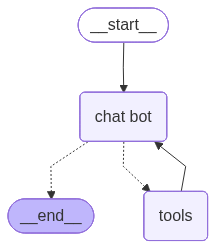

In [42]:
graph = StateGraph(ChatState)

graph.add_node("chat bot", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat bot")
graph.add_conditional_edges("chat bot",tools_condition)
graph.add_edge("tools", "chat bot")

chatbot = graph.compile()
chatbot

In [43]:
response=chatbot.invoke({"messages": [HumanMessage(content="my name is khushil")]})
response['messages'][-1].content

'Hello, Khushil! How can I assist you today?'

In [44]:
response=chatbot.invoke({"messages": [HumanMessage(content="stock price od apple")]})
response['messages'][-1].content

'The latest stock price for Apple (AAPL) is $278.28 as of the trading day December 12, 2025. The stock opened at $277.90, reached a high of $279.22, and a low of $276.82. The trading volume for the day was 39,532,887 shares.'

In [45]:
response=chatbot.invoke({"messages": [HumanMessage(content="what happened recently in Mumbai search online and tell me")]})
response['messages'][-1].content

'Based on the search results, it seems that Mumbai has a vibrant and ongoing lineup of events. The city offers various experiences, including food events, cultural attractions, and exciting happenings throughout the year. Specifically, there are notable events occurring in the coming weeks, with February being highlighted for a plethora of activities. \n\nIf you’re interested in more detailed or current events, let me know, and I can search further!'